### CSPB 3287 Project: Database Design for German Language App
#### Author: Sabine Hollatz

Video Presentation: https://drive.google.com/file/d/1hxvaB1HwkcCcQ7L44NDQhAIwdYz-qmUy/view
Git Repository:

### Motivation and Background
I have worked as a German language instructor teaching adults once a week. 
People in class were motivated by having a German Spouse or Ancestors, working 
for or with German companies, wanting to immigrate to German speaking countries, 
or were just generally interested in learning the language. Even though they were 
highly motivated, they could not find the time to build their vocabulary outside of 
class. Especially memorizing articles and grammatical forms can be cumbersome. So I 
started developing a web application which will make studying German words easier, more fun and available on the go. The app is basically a matching pairs game at this point, but will be extended at some point in the future.
Here is a link to the application: https://vocab-trainer-saholly.herokuapp.com/games
<br><br>

The previous state of the database consisted of one table, which contained a long list of potentially useful fields for nouns, adjectives and verbs, but at the moment only ~40 nouns are stored. The attributes were: word, partOfSpeech, translation1, translation2, translation3, meaning1, meaning2, article, gender, plural, thirdPersonPresent, thirdPersonPast, thirdPersonPerfect, separable, comparative, superlative, exampleSentence, user. This design includes many redundancies and null values.
The words were added by the user, which is cumbersome and error prone, and at the moment even incomplete. All users share the same pool of words. 

### The Project
Project Goal:
The user will be able to choose pairs of words and match them in a grammatically correct way. Currently only a few nouns and their corresponding articles are implemented. At the end of this project different parts of speech will be available, in different cases, genders and numbers. For example, matching pairs could be adjectives and nouns following gender and case specifications.  

The Database Design
The currently existing database will be normalized into the following 6 tables: 1. translation and meaning, 2. nouns, 3. verbs, 4. adjectives/adverbs, 5. personal pronouns, and 6. users. All words in the database and their translations will be kept in one table. Each word group will get its own table and contains the corresponding grammatical forms or suffixes. For now, 1-to-1 relationships between all word tables are sufficient. Proposed was that the user table would have many-to-many relationships with all other tables, however a many-to-many relationship with the translation relation is sufficient. This is, because the translation relation is connected to all other relations. Each user will be able to maintain a specific subset of words they are interested in practicing. 
Queries will be executed at the beginning of each game, when the words are selected, and during each game when pairs are checked if they match.

Tools and Interfaces
The design will be drawn and set up in MySQL workbench, where also the MySQL queries will be developed and debugged. The database will be exported to a MySQL instance on Google Cloud or Heroku, where, potentially, the web application will be deployed as well. For communications between the app and the database, two npm packages are used: mysql2 and sequelize. Sequelize provides the object-relational mapping (ORM). If I find a suitable word list, that might need minor adjustments, I will use a jupyter notebook for that.

Potential Problems
Feeding in data can become problematic. Currently, the users would input data themselves without error checking. To keep the database clean, I would like to build a word pool, that is certainly correct. Part of my project is to find suitable data for my design to fill the database. The worst case szenario is that I would need to maintain the data by hand. 

Learning Goals
I hope to learn how to maintain user specific subsets of a database, find secure ways to enable user input to the database by researching for and potentially adding existing word lists, matching them with my schema if time allows.


In [36]:
import sqlalchemy
from IPython.display import SVG, display, HTML
import base64

In [2]:
username = "root"
passwd = "Superfliege21"
host = "34.94.16.68"
dbname = "vocabTrainer"

In [3]:
db_string = "mysql://{0}:{1}@{2}/{3}".format(
    username, passwd, host, dbname)

In [4]:
try:
    engine = sqlalchemy.create_engine( db_string );
    conn = engine.connect()
except Exception as exp:
    print("Create engine failed: ", exp)

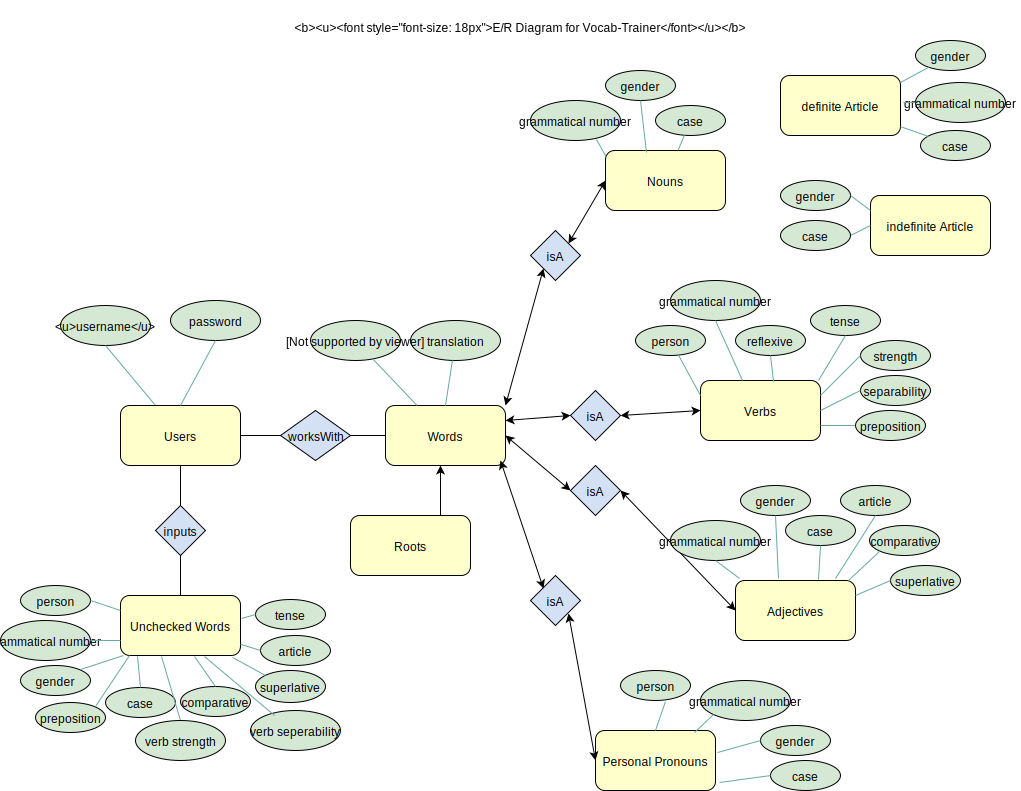

In [27]:
display(SVG(filename='./ER_vocabTrainer.svg'))

In [5]:
conn.execute("SHOW TABLES;").fetchall()

[('adjectives',),
 ('definiteArticles',),
 ('indefiniteArticles',),
 ('inputs',),
 ('nouns',),
 ('personalPronouns',),
 ('roots',),
 ('uncheckedWords',),
 ('users',),
 ('verbs',),
 ('words',),
 ('worksWith',)]

Previously nouns and definite articles, both in nominative, could be querried.
This should still be possible with the new design:

In [12]:
conn.execute("SELECT indefiniteArticles_article, indefiniteArticles_case FROM indefiniteArticles;").fetchall()

[('ein', 'N'),
 ('eine', 'N'),
 ('ein', 'N'),
 ('eines', 'G'),
 ('einer', 'G'),
 ('eines', 'G'),
 ('einem', 'D'),
 ('einer', 'D'),
 ('einem', 'D'),
 ('einen', 'A'),
 ('eine', 'A'),
 ('ein', 'A')]

In [21]:
conn.execute("SELECT nouns_noun, nouns_gender, nouns_nominative FROM nouns  WHERE nouns_nominative = 1;").fetchall()

[('Anzüge', 'M', 1),
 ('Bluse', 'F', 1),
 ('Blusen', 'F', 1),
 ('Erdgeschoss', 'N', 1),
 ('Größe', 'F', 1),
 ('Gürtel', 'M', 1),
 ('Hemd', 'N', 1),
 ('Hose', 'F', 1),
 ('Kleid', 'N', 1),
 ('Kleidung', 'F', 1),
 ('Kostüm', 'N', 1),
 ('Krawatte', 'F', 1),
 ('Mantel', 'M', 1),
 ('Ohrring', 'M', 1),
 ('Orientierung', 'F', 1),
 ('Pullover', 'M', 1),
 ('Rock', 'M', 1)]

In [74]:

conn.execute("SELECT definiteArticles_article, nouns_noun \
             FROM nouns, definiteArticles \
             WHERE nouns_nominative = 1 AND definiteArticles_case = 'N' AND nouns_gender = definiteArticles_gender \
             AND nouns_grammaticalNumber = 'S';").fetchall()

[('der', 'Gürtel'),
 ('der', 'Mantel'),
 ('der', 'Ohrring'),
 ('der', 'Pullover'),
 ('der', 'Rock'),
 ('die', 'Bluse'),
 ('die', 'Größe'),
 ('die', 'Hose'),
 ('die', 'Kleidung'),
 ('die', 'Krawatte'),
 ('die', 'Orientierung'),
 ('das', 'Erdgeschoss'),
 ('das', 'Hemd'),
 ('das', 'Kleid'),
 ('das', 'Kostüm')]

This works! Let's look at two more querries with nouns that have not been possible before - matching them with articles and adjectives in the right case.  

In [88]:
# Match adjectives and nouns in dative singular.
conn.execute("SELECT indefiniteArticles_article, adjectives_adjective, nouns_noun \
             FROM nouns, adjectives, indefiniteArticles \
             WHERE adjectives_case = 'D' AND nouns_dative = 1 AND indefiniteArticles_case = 'D' \
             AND adjectives_withIndefiniteArticle = 1 \
             AND adjectives_grammaticalNumber = 'S' AND nouns_grammaticalNumber = 'S' \
             AND nouns_gender = indefiniteArticles_gender AND adjectives_female = 1;").fetchall()   


[('einem', 'schönen', 'Gürtel'),
 ('einem', 'schönen', 'Mantel'),
 ('einem', 'schönen', 'Ohrring'),
 ('einem', 'schönen', 'Pullover'),
 ('einem', 'schönen', 'Rock'),
 ('einer', 'schönen', 'Bluse'),
 ('einer', 'schönen', 'Größe'),
 ('einer', 'schönen', 'Hose'),
 ('einer', 'schönen', 'Kleidung'),
 ('einer', 'schönen', 'Krawatte'),
 ('einer', 'schönen', 'Orientierung'),
 ('einem', 'schönen', 'Erdgeschoss'),
 ('einem', 'schönen', 'Hemd'),
 ('einem', 'schönen', 'Kleid'),
 ('einem', 'schönen', 'Kostüm')]

Nice! The final goal is to offer users to work with their own selection of words. 
Let's see if that works. 

In [105]:
conn.execute("SELECT users_name, words_word, words_englishTranslation \
              FROM worksWith, users, words \
              WHERE users_users_id = users_id AND words_words_id = words_id;").fetchall()

[('testUser1', 'Anzug', 'suit'),
 ('testUser1', 'Gürtel', 'belt'),
 ('testUser1', 'Hose', 'trousers'),
 ('testUser1', 'Kleidung', 'clothes'),
 ('testUser1', 'Krawatte', 'tie'),
 ('testUser1', 'Ohrringe', 'earring'),
 ('testUser1', 'Rock', 'skirt'),
 ('testUser1', 'Erdgeschoss', 'ground floor'),
 ('testUser1', 'schön', 'beautiful'),
 ('testUser1', 'gewöhnen', 'to get used to'),
 ('testUser1', 'ich', 'I'),
 ('testUser1', 'er', 'he'),
 ('testUser1', 'es', 'it'),
 ('testUser1', 'ihr', 'you'),
 ('testUser2', 'Bluse', 'blouse'),
 ('testUser2', 'Hemd', 'shirt'),
 ('testUser2', 'Kleid', 'dress'),
 ('testUser2', 'Kostüm', 'suit'),
 ('testUser2', 'Mantel', 'coat'),
 ('testUser2', 'Pullover', 'jumper'),
 ('testUser2', 'Orientierung', 'finding your way around'),
 ('testUser2', 'Größe', 'size'),
 ('testUser2', 'anbieten', 'to offer'),
 ('testUser2', 'hoffen', 'to hope'),
 ('testUser2', 'du', 'you'),
 ('testUser2', 'sie', 'she'),
 ('testUser2', 'wir', 'we'),
 ('testUser2', 'sie', 'they')]

### Open Source Tools and Wordlists
I found 2 potentially useful tools. The first is a wordlist and comes from the technical university TU Chemnitz in Germany (https://www-user.tu-chemnitz.de/~fri/ding/). It contains 345.000 entries of German nouns and their English translation. The second is a API calld linguatools (https://linguatools.org/language-apis/linguatools-translate-api/) which can be used to translate words and check their spelling. Due to time constraintes, these ressources will be implemented in the future.

### Discussion, Conclusion, and Future Development

The data base design itself took most of the time. I created 12 tables instead of the proposed 6 tables. This is because I would like to enable the user to insert new words but into a separate table first. This table is called uncheckedWords. It enables the user to work with their wanted words right away, but the entry cannot introduce mistakes to the core data base. The entries in the uncheckedWords table will be checked by other, advanced learners or myself. Another reason to add more tables than planned was to facilitate many-to-many relationships between the users and words tables as well as between the users and uncheckedWords tables. Furthermore, I decided to keep articles in their separate tables since they are a relatively small finite group of words. The database is deployed on Google Cloud and runs in MySQL.

I was able to find a word list with 345.000 entries of German words and their English translation and a translation and spell-checking API, which both will help to ensure correct user input. Unfortunately, I ran out of time to implement them during this project.

The structure of the word list is quite different compared to my layout, but I can use it to fill the core words table that only contains the German words in their general form and their English translations. Unfortunately, the grammatical forms are not included in the list and still would need to be put in manually. 

As might become clear from looking at the querries, I tried to keep one table per wordform to keep the layout as clear as possible. However, this came at the cost of some redundancy in the relations nouns, verbs, and adjectives. I tried to keep the redundancies down by introducing one-hot encodings in several attributes, but this causes the querries to become more complex (due to different systems). 

Overall, the proposed functionality was achieved. Grammatically correct matches can be made by querrying multiple relations with different word groups. For example, indefinite articles, adjectives and nouns have been matched in the correct case, grammaticalNumber, and gender. I achieved my learning goals of learning how to ensure safe user input, by restricting attributes in their data types (often using enumerate), finding word lists and tools to assist users during input and keeping a separate table with crowed sourcing manual checking for now.

In the future, the relations nouns, verbs, and adjectives, which contain redundancies, will be further normalized and the attributes adjusted to follow the same systematic patterns. The word list and the spell-checking and translation API will be implemented. Then, I can develope the frontend application further and connect it to the database. 